In [2]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
sys.path.append('../Supplementary_scripts')
print(sys.path)
import numpy as np
import os
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import plotly.figure_factory as ff
import networkx as nx
from pyvis.network import Network
import zipfile 
from bioservices import KEGG
#from K_func import translate_ko_terms


'''
Data prep and feature mapping
'''

os.chdir('/Users/eliah/Documents/Master/Eliah-Masters/Datasets')
# Paths to your uploaded files
zip_file_path_KO = "terms_KO.zip"
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'
# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.02)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)


# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"


['c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313', '', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\Pythonwin', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages', '../Data_Feature', '../Datasets', '../Supplementary_scripts', '../Data_Feature', '../Datasets', '../Supplementary_scripts']
Features with zero variance after filtering: 0


In [7]:
print(X_aligned.shape)
print(Y_aligned.shape)

(3256, 7149)
(3256,)


KO   K00001  K00002  K00003  K00004  K00005  K00007  K00008  K00009  K00010  \
key                                                                           
1       0.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
2       1.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
3       1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4       1.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
5       0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   

KO   K00011  ...  K22477  K22478  K22479  K22486  K22489  K22491  K22502  \
key          ...                                                           
1       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2       0.0  ...     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
3       0.0  ...     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
4       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0  

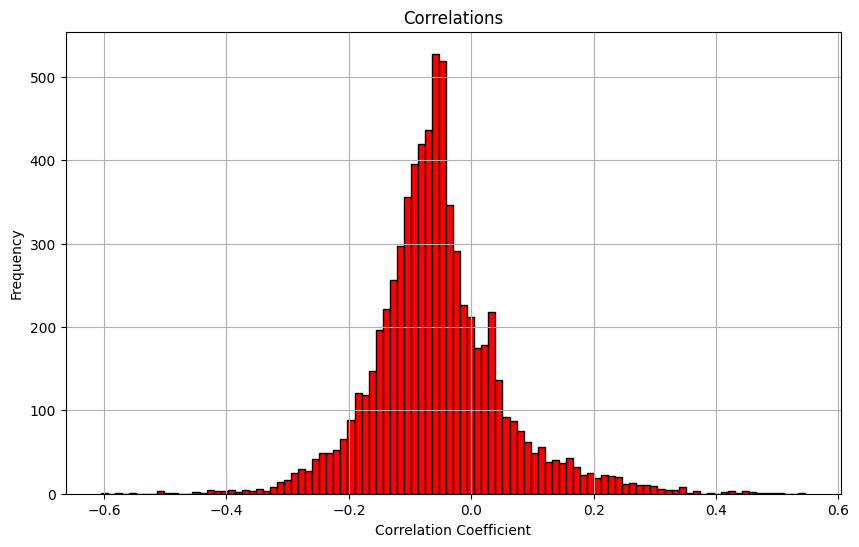

In [8]:
''' Calculating Pearsons coefficient'''

# Always look at data, right?
print(X_aligned.head())


'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Calculate Pearson correlation coefficients
corr_coefficients = [] # Collectes coefficents from X_aligned and Y_aligned calculations

# I should probably check how pearsons actually works


for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




Fitting 5 folds for each of 189 candidates, totalling 945 fits
Best parameters found: {'estimator': SVC(random_state=42), 'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'select_k__k': 500}
Best cross-validation score: 0.966
Matthews Correlation Coefficient: 0.8307288056358965


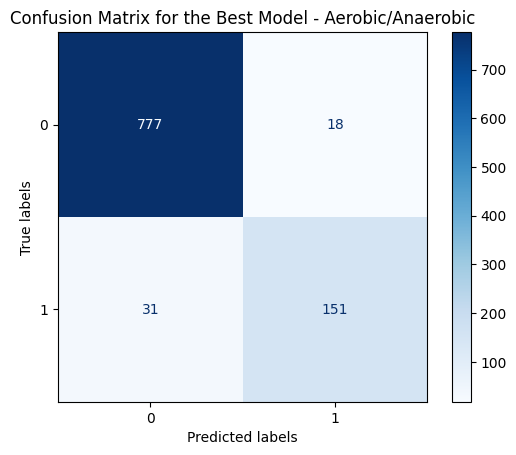

In [3]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need as needed  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k' : [10, 50, 100, 200, 300, 500, 1000],
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]



''' Grid search '''

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)


'''MCC shenanigans'''

mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")


# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for the Best Model - Aerobic/Anaerobic')
plt.show()


In [10]:
''' Finding best traits using f-scpre'''

'''# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=10)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

#Plot for visualizing distribution and importance of best traits

# Translate selected KO terms to their descriptions
selected_ko_terms_list = list(sorted_features)  
ko_descriptions_mapping = translate_ko_terms(selected_ko_terms_list)


# Replace KO terms with their descriptions for plotting
translated_sorted_features = [ko_descriptions_mapping[ko] for ko in sorted_features]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(translated_sorted_features)), sorted_scores)
plt.xticks(range(len(translated_sorted_features)), translated_sorted_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('F-scores')
plt.title('Top 50 KO Descriptions by F-score')
plt.tight_layout()
plt.show()
'''

'# Finding most predictive features with respect to target value (oxygen)\nselect_k_best = SelectKBest(f_classif, k=10)  \nX_new = select_k_best.fit_transform(X_aligned, Y_aligned)\nselected_features = select_k_best.get_support(indices=True)\n\n# Get the names of the selected KO terms\nselected_ko_terms = X_aligned.columns[selected_features]\n\n# Fitting select K best to find the scores\nselect_k_best.fit(X_aligned, Y_aligned)\nscores = select_k_best.scores_[selected_features] # scores of selected features\n\n# Sorting features by their scores\nsorted_indices = np.argsort(scores)[::-1]\nsorted_scores = scores[sorted_indices]\nsorted_features = selected_ko_terms[sorted_indices]\n\nprint("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")\nprint(sorted_features)\n\n#Plot for visualizing distribution and importance of best traits\n\n# Translate selected KO terms to their descriptions\nselected_ko_terms_list = list(sorted_features)  \nko_descriptions_mappi

Most selected KO terms for predicting oxygen trait in hierchical manner based on randomforest classifier:
This is model based feature importance (uses models own feature importance score to evaluate most important ones)
Index(['K01599', 'K00164', 'K07146', 'K03801', 'K02823', 'K11358', 'K02257',
       'K01163', 'K01772', 'K07138'],
      dtype='object', name='KO')


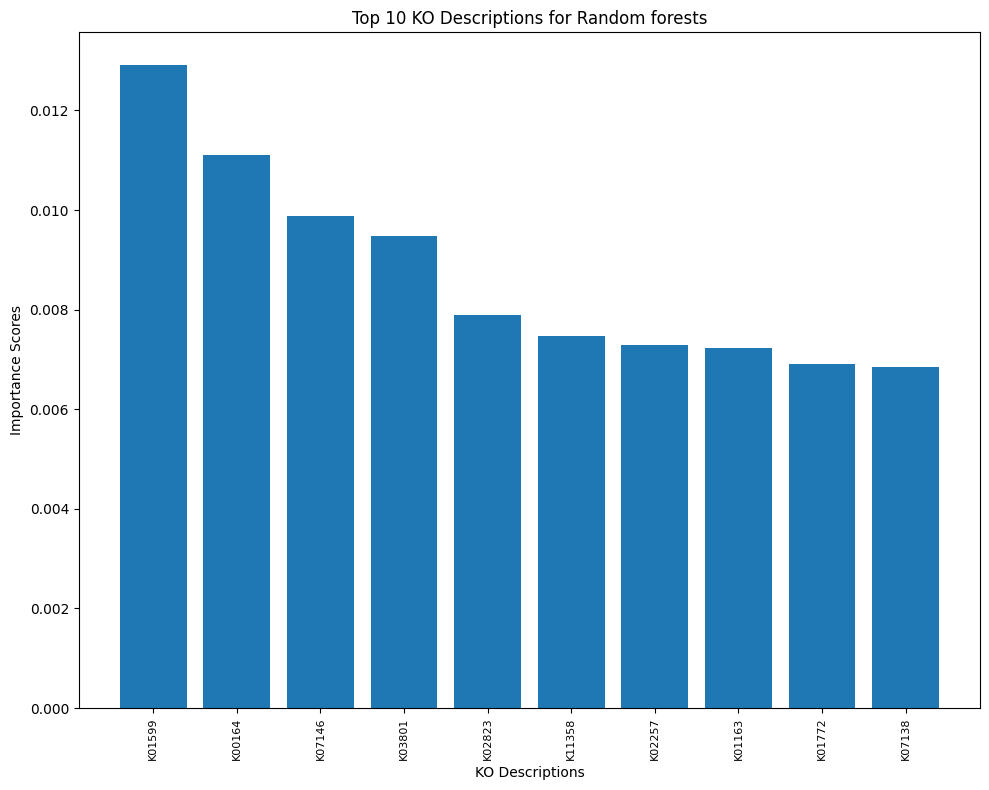

Most selected KO terms for predicting oxygen trait in hierchical manner based on logistic regression:
This is model based feature importance (uses model's coefficients as importance scores)
Index(['K03496', 'K03316', 'K03722', 'K04047', 'K01207', 'K05520', 'K02315',
       'K00425', 'K01182', 'K07727'],
      dtype='object', name='KO')


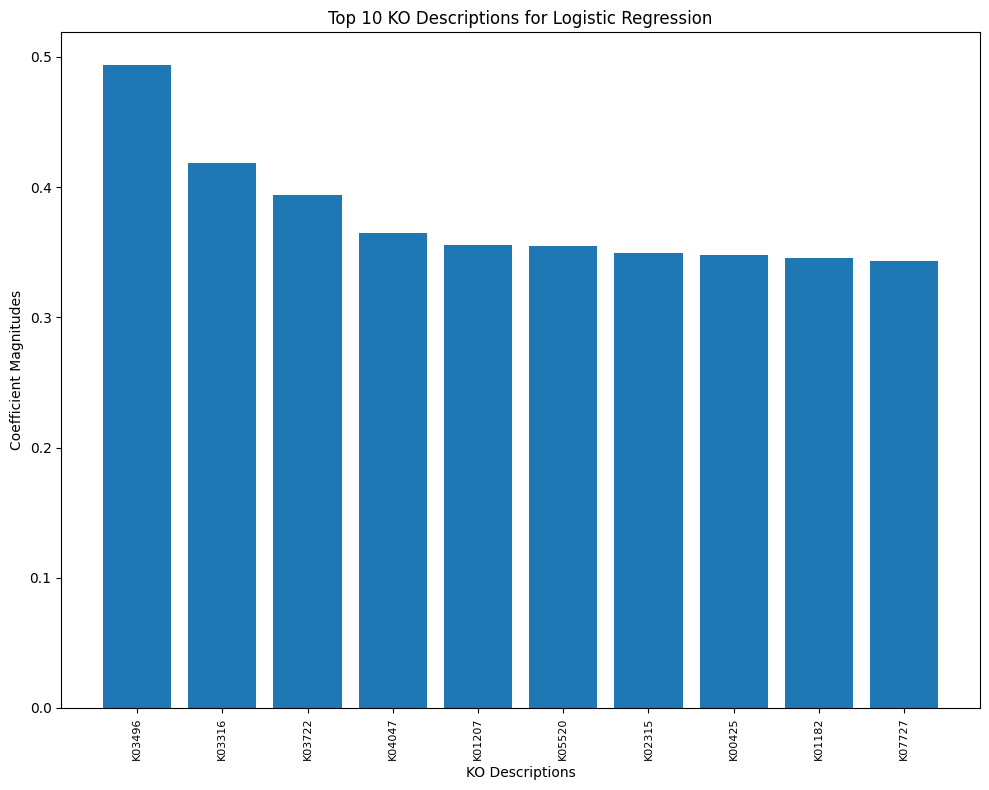

In [5]:
''' Model based feature importance score '''

#Fit a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_aligned, Y_aligned)

#Rank features by their importances
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 10 features
top_k_indices = sorted_indices[:10]
selected_features = X_aligned.columns[top_k_indices]

# Scores of selected features
sorted_scores = feature_importances[top_k_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner based on randomforest classifier:")
print("This is model based feature importance (uses models own feature importance score to evaluate most important ones)")
print(selected_features)

#Translate selected KO terms to their descriptions
translated_sorted_features = translate_ko_terms(list(selected_features))

# Prepare labels and scores for plotting
labels = [translated_sorted_features[ko] for ko in selected_features]
sorted_labels = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels)), sorted_scores)
plt.xticks(range(len(sorted_labels)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('Importance Scores')
plt.title('Top 10 KO Descriptions for Random forests')
plt.tight_layout()
plt.show()


''' For logsitc regression'''

#Fit a LogisticRegression model
lr_model = LogisticRegression()
lr_model.fit(X_aligned, Y_aligned)

#Rank features by their coefficients
lr_coefficients = lr_model.coef_[0]
sorted_indices_lr = np.argsort(np.abs(lr_coefficients))[::-1]

# Select the top 10 features
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

# Coefficients (importance) of selected features
sorted_scores_lr = lr_coefficients[top_k_indices_lr]

print("Most selected KO terms for predicting oxygen trait in hierchical manner based on logistic regression:")
print("This is model based feature importance (uses model's coefficients as importance scores)")
print(selected_features_lr)

#Translate selected KO terms to their descriptions
translated_sorted_features = translate_ko_terms(list(selected_features_lr))

# Prepare labels and scores for plotting
labels_lr = [translated_sorted_features[ko] for ko in selected_features_lr]
sorted_labels_lr = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels_lr)), np.abs(sorted_scores_lr))  # Use absolute value for visualization
plt.xticks(range(len(sorted_labels_lr)), translated_sorted_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('Coefficient Magnitudes')
plt.title('Top 10 KO Descriptions for Logistic Regression')
plt.tight_layout()
plt.show()


WARNING [bioservices.KEGG:130]:  The URL (http://rest.kegg.jp) provided cannot be reached.


Pathway matrix after renaming:
                                                     Porphyrin metabolism  \
hemE, UROD; uroporphyrinogen decarboxylase [EC:...                     1   
OGDH, sucA; 2-oxoglutarate dehydrogenase E1 com...                     0   
K07146; UPF0176 protein (K07146)                                       0   
lipB; lipoyl(octanoyl) transferase [EC:2.3.1.18...                     0   
pyrDII; dihydroorotate dehydrogenase electron t...                     0   
yhdR; aspartate aminotransferase [EC:2.6.1.1] (...                     0   
COX10, ctaB, cyoE; heme o synthase [EC:2.5.1.14...                     1   
K01163; uncharacterized protein (K01163)                               0   
hemH, FECH; protoporphyrin/coproporphyrin ferro...                     1   
K07138; uncharacterized protein (K07138)                               0   

                                                    Porphyrin metabolism  \
hemE, UROD; uroporphyrinogen decarboxylase [EC:...     

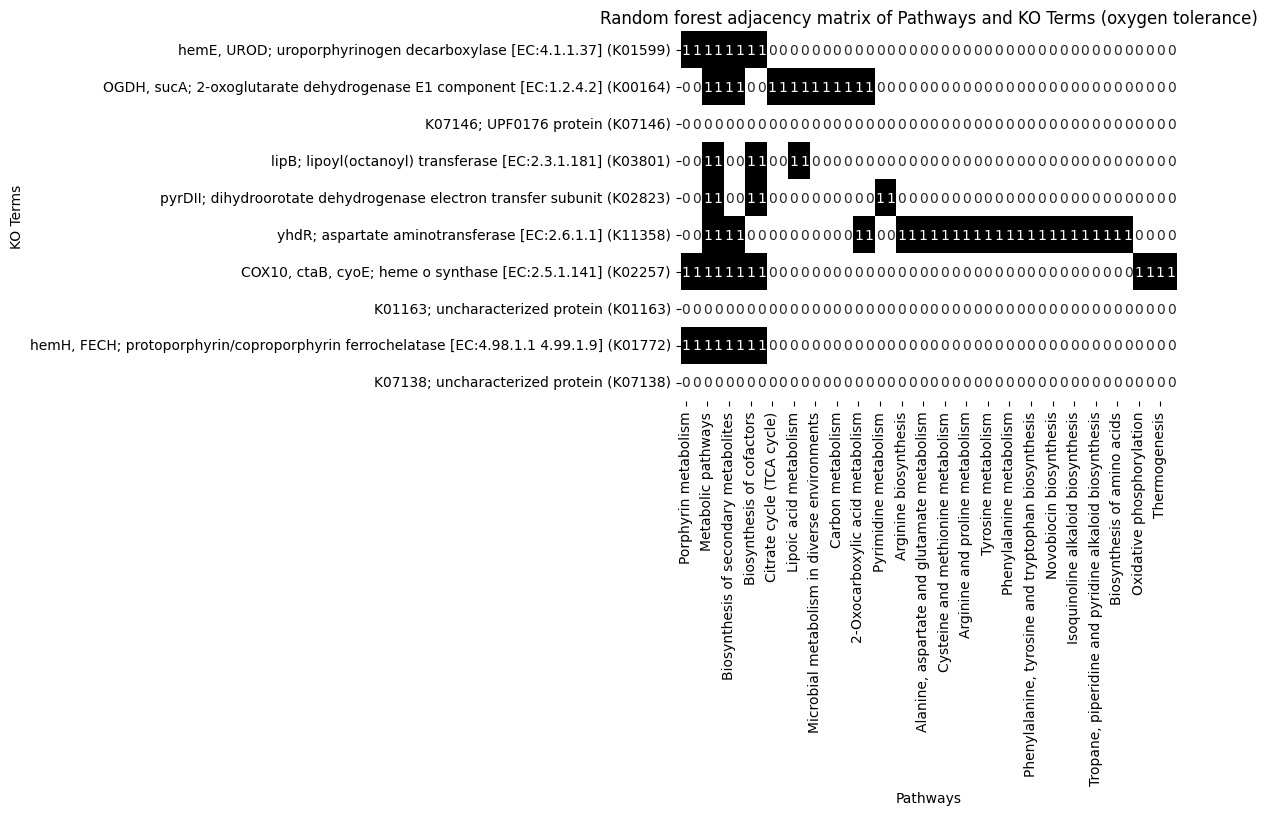

In [7]:
kegg = KEGG()

def translate_ko_terms(ko_terms):
    ko_descriptions = {}
    for ko in ko_terms:
        try:
            result = kegg.find("ko", ko)
            # The result can contain multiple lines if the term has multiple entries; split by newline
            first_line = result.split('\n')[0]
            # Each line is tab-separated with the format: entry_id, description
            _, description = first_line.split('\t', 1)
            ko_descriptions[ko] = description
        except Exception as e:
            print(f"Error retrieving information for {ko}: {e}")
            ko_descriptions[ko] = ko  # Use the KO term itself if the name can't be retrieved
    return ko_descriptions

def map_ko_to_pathways(ko_terms):
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = selected_features
pathways = map_ko_to_pathways(selected_important_features)
translated_kos = translate_ko_terms(selected_important_features)  

# Creating the adjacency matrix with translated KO terms, including original KO term
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
pathway_names = {}
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_names[column] = pathway_name
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title('Random forest adjacency matrix of Pathways and KO Terms (oxygen tolerance)')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Initialize a network graph
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading='Network of KOs and Pathways for Oxygentolerance (Based on Logistic regression) ', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])

nt.save_graph("KO_lrtest.html")


In [4]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 aerobic      1909
anaerobic     370
Name: count, dtype: int64
Unique labels in Y_train: ['aerobic' 'anaerobic']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279


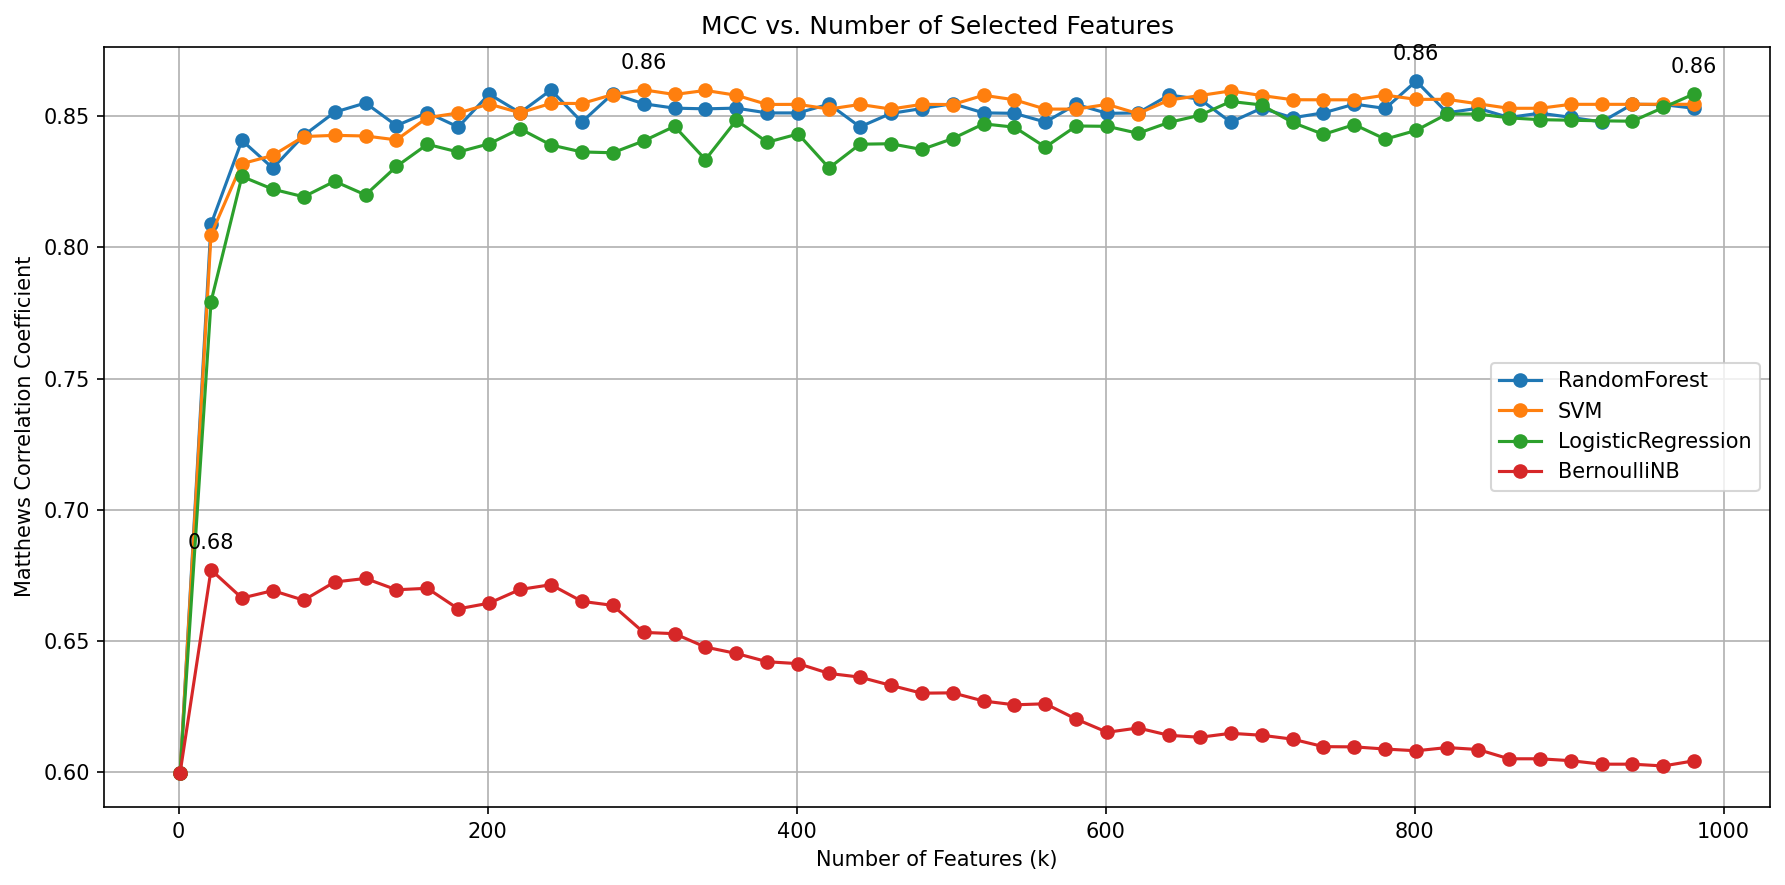

In [6]:
# Comparing MCC only

k_values = range(1, 1000, 20)

estimators = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Only keep MCC results
results = {name: [] for name in estimators}

cv = StratifiedKFold(n_splits=5)

for name, estimator in estimators.items():
    for k in k_values:
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('clf', estimator)
        ])
        mcc_scores = cross_val_score(
            pipeline, X_train, Y_train,
            cv=cv,
            scoring=make_scorer(matthews_corrcoef),
            n_jobs=-1
        )
        results[name].append(mcc_scores.mean())

# Plot MCC
plt.figure(figsize=(12, 6), dpi=150)
for name, mccs in results.items():
    ks = list(k_values)
    plt.plot(ks, mccs, marker='o', label=name)
    # annotate best point
    best_idx = np.nanargmax(mccs)
    plt.annotate(f'{mccs[best_idx]:.2f}',
                 (ks[best_idx], mccs[best_idx]),
                 textcoords='offset points', xytext=(0,10), ha='center')

plt.title('MCC vs. Number of Selected Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Matthews Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
Plot for LR vs RFS

# Fit models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting to aligned matrixes
lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)

# Get coefficients and feature importances
logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_
sorted_indices_rf = np.argsort(rf_feature_importance)[::-1]
sorted_indices_lr = np.argsort(logistic_importance)[::-1]


top_k_indices_rf = sorted_indices_rf[:10]
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_rf = X_aligned.columns[top_k_indices_rf]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

print(selected_features_rf)
print(selected_features_lr)

sorted_scores_rf = rf_feature_importance[top_k_indices_rf]
sorted_scores_lr = logistic_importance[top_k_indices_lr]


# Normalize the importance scores
scaler = MinMaxScaler()
lr_importance_scaled = scaler.fit_transform(logistic_importance.reshape(-1, 1)).flatten()
rf_importance_scaled = scaler.fit_transform(rf_feature_importance.reshape(-1, 1)).flatten()

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(lr_importance_scaled, rf_importance_scaled, alpha=0.6, color='red')

# Line of best fit
m, b = np.polyfit(rf_importance_scaled, lr_importance_scaled, 1)
ax.plot(rf_importance_scaled, m*rf_importance_scaled + b, color='blue')
ax.grid(True)
ax.set_xlabel('Logistic Regression Importance Scores (LR)')
ax.set_ylabel('Random Forest Importance Scores (RFS)')
ax.set_title('Comparison of Feature Importance Scores')

plt.show()

# Important to remember



#Logistic Regression Coefficients: After normalizing, they represent the relative predictive strength of features, 
#but they lose their direct probabilistic interpretation.

#Random Forest Feature Importances: They indicate how much each feature contributes to the predictive accuracy of the model, 
#based on how much each feature decreases the impurity of the splits.

#Maybe test rankings of features instead of normalized values. Can compare and see which features are consistently considered
#important across both models
'''


# Rank the features by importance for each model
lr_ranking = np.argsort(logistic_importance)[::-1]  # argsort returns indices that would sort the array
rf_ranking = np.argsort(rf_feature_importance)[::-1]


# For visualization
import pandas as pd

feature_names = X_aligned.columns  # For feature names
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'LR_Rank': lr_ranking.argsort(),
    'RF_Rank': rf_ranking.argsort(),
    'LR_Score': logistic_importance[lr_ranking.argsort()],
    'RF_Score': rf_feature_importance[rf_ranking.argsort()]
})


# Select top features by rank threshold or specific indices if needed
top_n = 10
ranking_df['Top_LR'] = ranking_df['LR_Rank'] < top_n
ranking_df['Top_RF'] = ranking_df['RF_Rank'] < top_n

# Now print or use this DataFrame for visualization
print(ranking_df.head(20))  # Display the first 20 entries for checking

''' 
# Sorts based on logisitc regression rank
#ranking_df.sort_values('LR_Rank', inplace=True)
# Can also sort by 'RF_Rank' 
# Ranks from random forests
#print(ranking_df[['Feature', 'LR_Rank', 'RF_Rank']].head(100))
# This shows the top 20 features as ranked by logistic regression, alongside their ranks in random forest
'''

# To find features that are consistently considered important, look for low rank numbers in both models
consistently_important_features = ranking_df[(ranking_df['LR_Rank'] < 100) & (ranking_df['RF_Rank'] < 100)]
print(consistently_important_features)



"importance" in logistic regression is based on the magnitude of the coefficients (which reflect the odds of the outcome), 
#while in random forests, importance is derived from how much a feature decreases the impurity of the splits.
'''

In [ ]:
# Assume X_aligned and Y_aligned are defined and appropriate for model fitting

# Fit models
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting to aligned matrices
lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)

# Get coefficients and feature importances
logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Rank the features by importance for each model
lr_ranking = np.argsort(logistic_importance)[::-1]  # argsort returns indices that would sort the array
rf_ranking = np.argsort(rf_feature_importance)[::-1]

# Normalize the importance scores
scaler = MinMaxScaler()
lr_importance_scaled = scaler.fit_transform(logistic_importance.reshape(-1, 1)).flatten()
rf_importance_scaled = scaler.fit_transform(rf_feature_importance.reshape(-1, 1)).flatten()


# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(lr_importance_scaled, rf_importance_scaled, alpha=0.6, color='red')

# Line of best fit
m, b = np.polyfit(rf_importance_scaled, lr_importance_scaled, 1)
ax.plot(rf_importance_scaled, m*rf_importance_scaled + b, color='blue')
ax.grid(True)
ax.set_xlabel('Logistic Regression Importance Scores (LR)')
ax.set_ylabel('Random Forest Importance Scores (RFS)')
ax.set_title('Comparison of Feature Importance Scores')

plt.show()


# For visualization
feature_names = X_aligned.columns  # Assuming your DataFrame columns are the feature names
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'LR_Rank': lr_ranking.argsort(),  # Convert indices to rank positions
    'RF_Rank': rf_ranking.argsort(),
    'LR_Score': logistic_importance[lr_ranking.argsort()],  # Order scores by original feature order
    'RF_Score': rf_feature_importance[rf_ranking.argsort()]
})

# Sort DataFrame based on what is needed
ranking_df.sort_values('RF_Rank', ascending=True, inplace=True)

# Select top features by rank threshold or specific indices if needed
top_n = 10
ranking_df['Top_LR'] = ranking_df['LR_Rank'] < top_n
ranking_df['Top_RF'] = ranking_df['RF_Rank'] < top_n

# Display the first 20 entries for checking
print(ranking_df.head(20))

# To find features that are consistently considered important, look for low rank numbers in both models
consistently_important_features = ranking_df[(ranking_df['LR_Rank'] < 100) & (ranking_df['RF_Rank'] < 100)]
print(consistently_important_features)




In [ ]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''


lr_model = LogisticRegression(solver='lbfgs', penalty="l2")
rf_model = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_split=5, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")
#print(f"P-Value: {p_value:.3f}")

# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Some comments on the plot:

Bootstrapping was done to simulate calculating pearsons with multiple variables against a single response variable. The bootstrappiing segments the data to generate a distribution of pearson coeffiecients

Bootstrapping randomly samples the data with replacemnet, calculating pearsons for each sample and reapting this many times for the distribution

Gives a sense os how the relationship between LR and RF mighjt vary across different random samples of the data

Pvalue is 0.00???

The weak but positive relationship suggests that when features are considered important in one model, this also seems to be the case in the other.
However, degree of importance does not seem to be aligning

Positive but not strong relationship.

Logisitic regression may be more sensitive to linear relationships while randomforestes may capture none-linear dependancies better.

Pearson correlation coefficent is invariant, but the way the feature impact the model output probably varies a lot. (If feature have different scales, which i think they do, at least the importance)

LR gives negative or positive coefficents, refelcting the direction and strength of the relationship with the dependant variable
RF uses a measure based on how much each feature decreases the impurity of the splits. This wont nesecarilly imply direction, only the usefullness or utility of the feature in node splitting

